In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 07d
## Working with PyTorch
- one hidden layer 
- ${tanh}$ activation function
- multi-class output
- FIFA dataset
- with torch framework

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
import os
#import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


In [3]:
# Some basic parameters
inpDir = '../input'
outDir = '../output'
modelDir = '../models'
modelSubDir = 'pytorch_fifa'

RANDOM_STATE = 24
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 20001 # number of epochs
ALPHA = 0.1 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)

In [4]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, modelSubDir)):
    os.makedirs(os.path.join(modelDir, modelSubDir))
    print ('Created {} directory'.format(os.path.join(modelDir, modelSubDir)))

## Helper Function to Plot Loss and accuracy

In [26]:
def plot_hist(hist_df):
    
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    l_range = 10

    ax = axes[0]

    hist_df.plot(x = 'epoch', y = 'loss', ax = ax)
    loss = loss_df['loss'].values

    # little beautification
    txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[0],loss[-1]) #text to plot
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords

    ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Error")
    ax.set_title('Overall')
    ax.grid();

    ax = axes[1]

    hist_df[-l_range:].plot(x = 'epoch', y = 'loss', ax = ax)

    # little beautification
    txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[-l_range],loss[-1]) #text to plot
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords

    ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Error")
    ax.set_title('Last {} records'.format(l_range))
    ax.grid();
    plt.tight_layout()

## Read FIFA 2019 data set

In [6]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [7]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [8]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [9]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [10]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Helps in preventing pandas from complaining while get_dummies
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [11]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [12]:
y = data_df["Position"].values

X = data_df.drop("Position", axis = 1)

# one hot encoding
y = pd.get_dummies(y).values
X.shape, y.shape

((18147, 33), (18147, 4))

In [13]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14517, 33) (14517, 4) (3630, 33) (3630, 4)


In [14]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.fit_transform(X_test)

## All about CUDA

In [15]:
print ('Is CUDA available: ', torch.cuda.is_available())

print ('CUDA version: ', torch.version.cuda )

print ('Current Device ID: ', torch.cuda.current_device())

print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

Is CUDA available:  True
CUDA version:  11.7
Current Device ID:  0
Name of the CUDA device:  NVIDIA GeForce RTX 3060 Laptop GPU


In [16]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


In [17]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim,16)
        self.layer2 = nn.Linear(16, 4)
        
    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = F.softmax(self.layer2(x), dim = 1)
        return x

net = Model(X_train.shape[1]).to(device) # Create model on GPU
print (net)

Model(
  (layer1): Linear(in_features=33, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=4, bias=True)
)


In [18]:
# wrap up with Variable in pytorch and transfer them to GPU
train_X = Variable(torch.Tensor(X_train).float()).to(device) 
test_X = Variable(torch.Tensor(X_test).float()).to(device)
train_y = Variable(torch.Tensor(y_train).float()).to(device)
test_y = Variable(torch.Tensor(y_test).float()).to(device)

In [19]:
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss = []
n_epoch = []

optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

for epoch in range(EPOCHS):
    
    # Compute prediction error
    y_pred = net(train_X)
    
    curr_loss = loss_fn(y_pred, train_y)
    
    # Backpropagation
    optimizer.zero_grad() # reset to zero before starting backprop for this epoch 
    curr_loss.backward() # using current loss backprop the loss
    optimizer.step() # perform a parameter update based on the current gradient
    
    if epoch % 100 == 0:
        loss.append(curr_loss.data.item())
        n_epoch.append(epoch)
    
    if epoch % 1000 == 0:
        print ('number of epoch: {:5d} | Loss : {:.5f}'.format( epoch, curr_loss.data.item()) ) 

predict_out = net(test_X)
_, predict_y = torch.max(predict_out, 1)

number of epoch:     0 | Loss : 1.40725
number of epoch:  1000 | Loss : 1.04080
number of epoch:  2000 | Loss : 0.96210
number of epoch:  3000 | Loss : 0.93186
number of epoch:  4000 | Loss : 0.91571
number of epoch:  5000 | Loss : 0.90568
number of epoch:  6000 | Loss : 0.89892
number of epoch:  7000 | Loss : 0.89413
number of epoch:  8000 | Loss : 0.89057
number of epoch:  9000 | Loss : 0.88785
number of epoch: 10000 | Loss : 0.88567
number of epoch: 11000 | Loss : 0.88389
number of epoch: 12000 | Loss : 0.88240
number of epoch: 13000 | Loss : 0.88111
number of epoch: 14000 | Loss : 0.88000
number of epoch: 15000 | Loss : 0.87901
number of epoch: 16000 | Loss : 0.87814
number of epoch: 17000 | Loss : 0.87735
number of epoch: 18000 | Loss : 0.87663
number of epoch: 19000 | Loss : 0.87598
number of epoch: 20000 | Loss : 0.87539


In [20]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                       'loss' : loss})

In [21]:
print ('prediction accuracy : {:.4f}'.format(accuracy_score(y_test.argmax(axis = 1), predict_y.data.cpu())))

prediction accuracy : 0.8736


In [22]:
print(classification_report(y_test.argmax(axis = 1), predict_y.data.cpu()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       417
           1       0.90      0.92      0.91      1168
           2       0.82      0.85      0.84      1349
           3       0.85      0.76      0.80       696

    accuracy                           0.87      3630
   macro avg       0.89      0.88      0.89      3630
weighted avg       0.87      0.87      0.87      3630



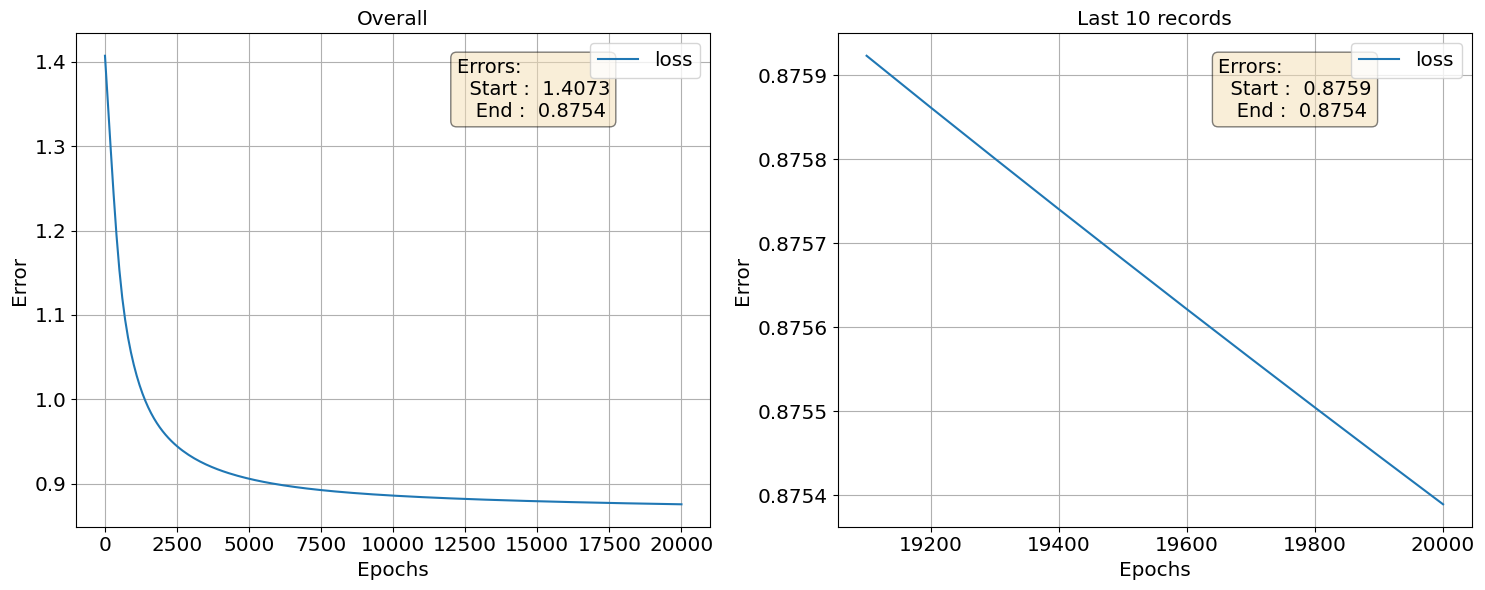

In [28]:
plot_hist(loss_df)

## Using DataSets

So far we used Pandas to load data and then manually attached it to GPU. We can also use PyTorch's built in functionality to load data.

This time we will be loading images from a subdirectory in the local drive 

In [23]:
from torchvision import datasets, transforms

In [24]:
# Images are all kind of shaoes and sizes. We need to standardoze the data
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()
                               ])

dataset = datasets.ImageFolder(os.path.join(inpDir, 'flower_photos'), transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True) # 

In [25]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

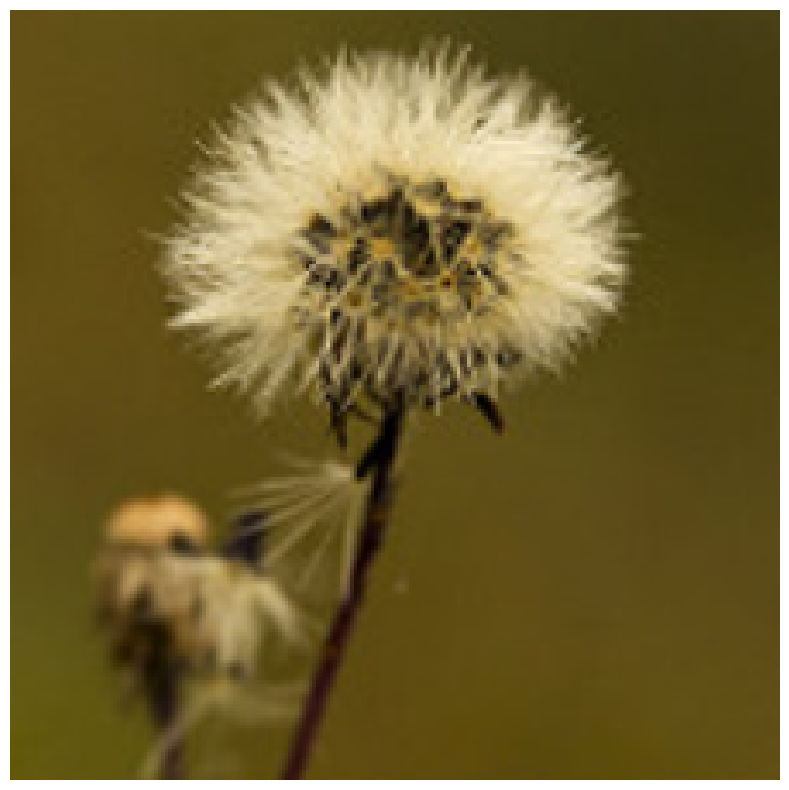

In [26]:
# Run this to test your data loader
images, labels = next(iter(dataloader))
# helper.imshow(images[0], normalize=False)
imshow(images[0], normalize=False);

In [27]:
images[0].shape

torch.Size([3, 224, 224])

In [28]:
images[0]

tensor([[[0.3922, 0.3882, 0.3882,  ..., 0.2863, 0.2902, 0.2902],
         [0.3882, 0.3843, 0.3882,  ..., 0.2902, 0.2902, 0.2902],
         [0.3882, 0.3843, 0.3882,  ..., 0.2902, 0.2902, 0.2902],
         ...,
         [0.3843, 0.3882, 0.3843,  ..., 0.3804, 0.3804, 0.3804],
         [0.3843, 0.3882, 0.3882,  ..., 0.3804, 0.3804, 0.3804],
         [0.3843, 0.3882, 0.3882,  ..., 0.3804, 0.3804, 0.3804]],

        [[0.3137, 0.3137, 0.3137,  ..., 0.2510, 0.2549, 0.2549],
         [0.3098, 0.3098, 0.3137,  ..., 0.2549, 0.2549, 0.2549],
         [0.3098, 0.3098, 0.3137,  ..., 0.2549, 0.2549, 0.2549],
         ...,
         [0.3412, 0.3451, 0.3412,  ..., 0.3098, 0.3098, 0.3098],
         [0.3412, 0.3451, 0.3412,  ..., 0.3059, 0.3059, 0.3059],
         [0.3412, 0.3412, 0.3412,  ..., 0.3059, 0.3059, 0.3059]],

        [[0.0824, 0.0863, 0.0863,  ..., 0.0824, 0.0863, 0.0863],
         [0.0784, 0.0824, 0.0863,  ..., 0.0863, 0.0863, 0.0863],
         [0.0784, 0.0824, 0.0863,  ..., 0.0863, 0.0902, 0.

## [Recommended Reading](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)

For more on PyTorch Examples